# Towards a standard format for provenance information for WPS tools and services

## Version 0.1 (Birdhouse WPS Joint Workshop (IS-ENES, Convergence, CLIPC, EUCLEIA)I coding sprint version - 15.Okt.2015)

Status: 
* Most evaluation tool effors (like ESMValTool and Climaf) provide information about the provenance of generated results
* The format and content is different
* In ESMValTool the provenance log generating parts are spread all over the source code --> no simple prov API integration for the near future --> translation of prof log end results to standard W3C prov format

    > *Info from Axel*:
    > point where file informations is collected:
    * reformat_scripts/defaults/reformat_default_main.ncl
    * reformat_scripts/defaults/reformat_default_func.ncl (read_var , apply_fixes)
    * reformat_scripts/constants.ncl (write_output)
    * interface_scripts/messaging.ncl (main, write_header, write_flist, write_references)
    * interface_scripts/data_handling.ncl (main, add_data_var, read_data)
    * other info is written in indiv. diagnosis (ncl) scripts and collected by the wrappers

Steps forward: 
* Generate W3C Prov standard conformant provenance descriptions - these can then be stored / exchanged / queried as well as combined using standard and generic tools
* Generate translation tools for ESMValTool provenance log output to W3C Prov (seriazable to json and xml)
* Provide a simple python API to generate provenance files (based on W3C Prov)

## Installation of W3C PROV standard python library

To install the prov library using [pip](http://pip.pypa.io/) with support for graphical exports:
```bash
pip install prov[dot]
```
Code Repository: https://github.com/trungdong/prov

Documentation: http://prov.readthedocs.org/en/latest/


## Simple API (v0.1)

Parameters In:
* list of input elements (e.g. files)
* list of generated output elements
* generting_process (tool, wps)
* author (agent info)

Result:
* python prov element, which can be serialized (into W3C Prov standardized json and xml), printed and visualized
dictionary (using specific keys from a CV) with provenance information--> prov document

In [1]:
## ToDo: improve and write tests

from prov.model import ProvDocument
from IPython.display import Image

def generate_prov(input_files, output_files, generating_process, author):
    '''
    Generates Prov model entities and prov model relationships between them
    
    output python prov instance which can be serialized/de-serialized based on json 

    '''
    d1 = ProvDocument()
    # Namespaces should be imported from a central place 
    # e.g. a simple controled vocab server, or github later
    d1.add_namespace('enes', 'http://www.enes.org/enes_entitiy/')
    d1.add_namespace('file', 'http://www.enes.org/enes_entity/file/')
    d1.add_namespace('user', 'http://www.enes.org/enes_entity/user/')
    d1.add_namespace('esgf', 'http://carbon.dkrz.de/file/cmip5/')
    d1.add_namespace('enes_data', 'http://enes_org/enes_data#')
    d1.add_namespace('dc','http://dublin-core.org/')
    d1.add_namespace('workflow', 'http://www.enes.org/enes/workflow/#')
    
    inputs = []
    for i,entry in enumerate(input_files):
        inputs.append(d1.entity(entry['name'], entry['properties']))

    outputs = []
    for i,entry in enumerate(output_files):
        outputs.append(d1.entity(entry['name'], entry['properties']))
    
    processor = d1.activity(generating_process['name'])

    the_agent = d1.agent(author['name'])
    
    # AttributedTo relationships
    for i,entry in enumerate(output_files):
      d1.wasAttributedTo(outputs[i],author['name'] )

    # wasDerivedFrom relationships
    for i,out_entry in enumerate(output_files):
        for j,in_entry in enumerate(input_files):
            d1.wasDerivedFrom(out_entry['name'], in_entry['name'])
            
    # used and wasGeneratedBy relationships
    for i, in_entry in enumerate(input_files):
        d1.used(generating_process['name'], in_entry['name'])
    
    for j, out_entry in enumerate(output_files):
        d1.wasGeneratedBy(out_entry['name'], generating_process['name'])   
        
    return d1 

def visualize_prov(prov_doc):
    from prov.dot import prov_to_dot
    from IPython.display import Image
    dot = prov_to_dot(prov_doc)
    dot.write_png('tmp1.png')
    #dot.write_pdf('tmp1.pdf')
    
    return Image('tmp1.png')
    

In [4]:
# Example input, output and tool/WPS process as well as agent

input_files = [{'name':'esgf:cmip5.mpi-m.tas.v1', 
                'properties': {'prov:label': 'experiment-mpi-m', 
                               'prov:type': 'Dataset', 
                               'dc:title':"eval_series_1"}},
               {'name':'esgf:cmip5.miroc.tas.v1', 
                'properties': {'prov:label': 'experiment-miroc', 
                               'prov:type': 'Dataset', 
                               'dc:title':"eval_series_1"}}
             ]
output_files = [{'name':'enes:temporal-mean-result1-v1.nc',
                 'properties':{'dc:title':'eval_series_1_1'}}
               ]
generating_process = {'name':'workflow:temporal-mean-cdo',
                      'properties':{'prov:label': 'experiment-mpi-m', 
                                    'prov:type': 'enes_data:Dataset', 
                                    'dc:title':'esmval-analysis-a1'}
                                   }
author = {'name':'enes:Stephan Kindermann'}

In [5]:
# generate example provenance object
prov_doc = generate_prov(input_files,output_files,generating_process,author)

In [6]:
# print serialized provenance object
print prov_doc.get_provn()

document
  prefix enes <http://www.enes.org/enes_entitiy/>
  prefix workflow <http://www.enes.org/enes/workflow/#>
  prefix dc <http://dublin-core.org/>
  prefix user <http://www.enes.org/enes_entity/user/>
  prefix file <http://www.enes.org/enes_entity/file/>
  prefix esgf <http://carbon.dkrz.de/file/cmip5/>
  prefix enes_data <http://enes_org/enes_data#>
  
  entity(esgf:cmip5.mpi-m.tas.v1, [prov:type="Dataset", dc:title="eval_series_1", prov:label="experiment-mpi-m"])
  entity(esgf:cmip5.miroc.tas.v1, [prov:type="Dataset", dc:title="eval_series_1", prov:label="experiment-miroc"])
  entity(enes:temporal-mean-result1-v1.nc, [dc:title="eval_series_1_1"])
  activity(workflow:temporal-mean-cdo, -, -)
  agent(enes:Stephan Kindermann)
  wasAttributedTo(enes:temporal-mean-result1-v1.nc, enes:Stephan Kindermann)
  wasDerivedFrom(enes:temporal-mean-result1-v1.nc, esgf:cmip5.mpi-m.tas.v1, -, -, -)
  wasDerivedFrom(enes:temporal-mean-result1-v1.nc, esgf:cmip5.miroc.tas.v1, -, -, -)
  used(workf

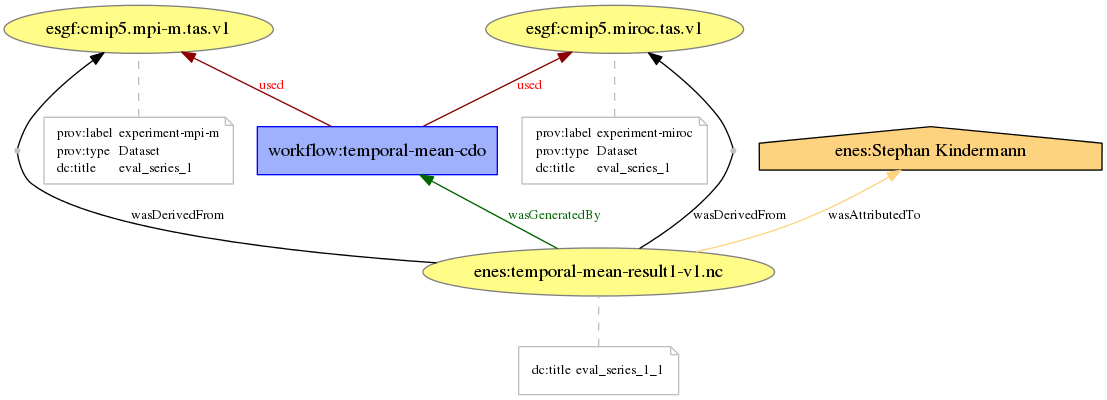

In [7]:
# visualize
visualize_prov(prov_doc)

## PROV-JSON export

[PROV-JSON](https://provenance.ecs.soton.ac.uk/prov-json/) is natively supported by the library and is the default serialisation format.

In [ ]:
# serialize / desirialize
serialized_version = prov_doc.serialize()
print serialized_version

In [ ]:
print prov_doc.serialize(indent=2)

You can also serialize the document directly to a file by providing a filename (below) or a Python File object.

In [ ]:
prov_doc.serialize('esgf-prov.json')

A PROV-JSON file can also be deserialised into a `ProvDocument` instance as follows.

In [ ]:
d2 = ProvDocument.deserialize('esgf-prov.json')
prov_doc == d2  # Is it the same document we saved earlier?

In [ ]:
# ToDo

* write simple wrapper (based on API 0.1) to translate esmValTool output into WC3 prov document (json) 
* extend API to be used in birdhouse to generate prov documents 
* publish birdhouse result prov information along result files (in the birdhouse CSW catalog and/or ProvStore)


## May be useful: Store and retrieve provenance documents from ProvStore

Having the created a provenance document, you can upload it to [ProvStore](https://provenance.ecs.soton.ac.uk/store/), a free repository for provenance documents, to share it publicly/privately, or simple just to store and retrieve it back at a later time.
In addition to storage and sharing, you can also retrieve your documents on ProvStore in further formats like XML and RDF, transform, and/or visualise them in various ways (see [this poster](http://eprints.soton.ac.uk/365509/) for more information).

Before storing your document there, you need to [register for an account](https://provenance.ecs.soton.ac.uk/store/account/signup/). You can then upload the PROV-N or PROV-JSON export above via ProvStore's website. However, if you [generated an API Key](https://provenance.ecs.soton.ac.uk/store/account/developer/) for your account, you can also upload the document there directly from this tutorial as shown below.

A wrapper for [ProvStore's REST API](https://provenance.ecs.soton.ac.uk/store/help/api/) is provided by the package [provstore-api](https://github.com/millar/provstore-api#installation). Please follow the [installation instructions](https://github.com/millar/provstore-api#installation) there before proceeding.

In [ ]:
# Configure ProvStore API Wrapper with your API Key
from provstore.api import Api
# see your API key at https://provenance.ecs.soton.ac.uk/store/account/developer/
api = Api(username='your ProvStore username', api_key='your API key')

In [ ]:
# Submit the document to ProvStore
provstore_document = api.document.create(d1, name='article-prov', public=True)

# Generate a nice link to the document on ProvStore so you don't have to find it manually 
from IPython.display import HTML
document_uri = provstore_document.url
HTML('<a href="%s" target="_blank">Open your new provenance document on ProvStore</a>' % document_uri)

The first statement above submit the document `d1` to ProvStore, giving it a name (required) and making it visible to everyone (optional and private by default). Clicking on the link generated will open the page on ProvStore for the document you just submitted.

The returned object is a wrapper for the document on ProvStore identified by `provstore_document.id`, with which you can, of course, retrieve the document again from ProvStore.

In [ ]:
# Retrieve it back
retrieved_document = api.document.get(provstore_document.id)
d2 = retrieved_document.prov
d1 == d2  # Is it the same document we submitted?

You can also remove the document from ProvStore via its API. It is a good idea to leave your account there nice and tidy anyway.

In [ ]:
# Cleaning up, delete the document
retrieved_document.delete()

In [ ]:
# Just to be sure, trying to retrieve it again
#api.document.get(provstore_document.id)  # the document is no longer there

## Further reading

There it is, through a very short tutorial, you have managed to create a provenance document, export it, and store it on the cloud. Simple!

If you want to find out more about how to use the library and ProvStore, here are some references:
* [Prov Python library's documentation](http://prov.readthedocs.org)
* [ProvStore's API documentation](https://provenance.ecs.soton.ac.uk/store/help/api/)
* [Overview of the PROV standards](http://www.w3.org/TR/prov-overview/)


<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" href="http://purl.org/dc/dcmitype/InteractiveResource" property="dct:title" rel="dct:type"> This notebook</span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.